In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from torchvision import datasets, transforms
import torch.nn as nn
import torch
from torchinfo import summary
from scipy.linalg import sqrtm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/MyDrive/study/andan/dl_4_lab/'
device = "cpu"
diff_steps = 100

Mounted at /content/drive


## Data

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
    (0.1307,), (0.3081,))
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle = True, pin_memory=True, num_workers=0)

## Funtions

In [ ]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(16, 4, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(4, 16, 2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 1, 2, stride=2),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 1, 4, stride=4),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
def train_ae(model, train_loader, n_epochs, save_path_model, save_path_losses):
    losses = []
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    best_loss = 100000
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0

        for data in train_loader:
            images, _ = data
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss/len(train_loader)
        losses.append(train_loss)
        if train_loss < best_loss:
            print("save model")
            torch.save(model.state_dict(), save_path_model)
            best_loss = train_loss
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f}')
    with open(save_path_losses, 'w') as f:
        for line in losses:
            f.write(f"{line}\n")
    return losses

In [ ]:
def train_denoiser(denoiser, T, train_loader, n_epochs, save_path_model, save_path_losses, latent_dim = 28*28, n_epoch=50):
    losses = []
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    best_loss = 100000
    for epoch in range(n_epochs):
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            t = torch.randint(0, T, (x.size(0),), device=device)
            noise = torch.randn_like(x)
            x_noisy = forward_diffusion(x, t, noise)
            t_norm = t.float().unsqueeze(1) / T
            noise_pred = model(x_noisy, t_norm, y)
            loss = criterion(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss/len(train_loader)
        losses.append(train_loss)
        if train_loss < best_loss:
            torch.save(denoiser.state_dict(), save_path_model)
            best_loss = train_loss
        print(f'Epoch: {epoch + 1} \tTraining Loss: {train_loss:.6f}')
    with open(save_path_losses, 'w') as f:
        for line in losses:
            f.write(f"{line}\n")
    return losses

In [ ]:
def train_denoiser_ae(ae, denoiser, T, train_loader, n_epochs, save_path_model, save_path_losses):
    losses = []
    criterion = nn.MSELoss()
    opt_denoiser = torch.optim.Adam(denoiser.parameters(), lr=1e-4)
    best_loss = 100000
    for epoch in range(n_epochs):
        train_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                x_reshaped = x.view(x.size(0), 1, 28, 28)
                z = ae.encoder(x_reshaped)
                z = z.view(z.size(0), -1)
            t = torch.randint(0, T, (x.size(0),), device=device)
            noise = torch.randn_like(z)
            z_noisy = forward_diffusion(z, t, noise)
            t_norm = t.float().unsqueeze(1) / (T - 1)
            noise_pred = denoiser(z_noisy, t_norm, y)
            loss = criterion(noise_pred, noise)
            opt_denoiser.zero_grad()
            loss.backward()
            opt_denoiser.step()
            train_loss += loss.item()
        train_loss = train_loss/len(train_loader)
        losses.append(train_loss)
        if train_loss < best_loss:
            print("save model")
            torch.save(denoiser.state_dict(), save_path_model)
            best_loss = train_loss
        print(f'Epoch: {epoch + 1} \tTraining Loss: {train_loss:.6f}')
    with open(save_path_losses, 'w') as f:
        for line in losses:
            f.write(f"{line}\n")
    return losses

In [ ]:
class MultivariateGaussianGenerator:
    def __init__(self, regularization=1e-6):
        self.regularization = regularization

    def fit(self, data):
        self.mean = np.mean(data, axis=0)
        self.cov = np.cov(data, rowvar=False)

        self.cov += np.eye(self.cov.shape[0]) * self.regularization

        self.L = sqrtm(self.cov)

    def generate(self, n_samples=100):
        return np.random.multivariate_normal(
            self.mean,
            self.cov,
            size=n_samples
        )

In [ ]:
class SimpleSMOTE:
    def __init__(self, k=5):
        self.k = k

    def generate(self, data, n_samples=500):
        synthetic = []
        nbrs = NearestNeighbors(n_neighbors=self.k).fit(data)

        for _ in range(n_samples):
            i = np.random.randint(len(data))
            neighbors = nbrs.kneighbors([data[i]], return_distance=False)[0]
            j = np.random.choice(neighbors)
            alpha = np.random.rand()
            synthetic.append(data[i] + alpha*(data[j] - data[i]))

        return np.array(synthetic)

In [ ]:
class ConditionalDenoiser(nn.Module):
    def __init__(self, n_class, latent_dim, emb_dim=32):
        super().__init__()
        self.class_emb = nn.Embedding(n_class, emb_dim)
        self.time_emb = nn.Linear(1, emb_dim)
        self.net = nn.Sequential(
            nn.Linear(latent_dim + 2*emb_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim),
        )

    def forward(self, z, t, class_label):
        class_emb = self.class_emb(class_label)
        time_emb = self.time_emb(t)
        inp = torch.cat([z, time_emb, class_emb], dim=1)
        return self.net(inp)

In [ ]:
class ConditionalDenoiser2(nn.Module):
    def __init__(self, n_class, latent_dim=28*28, emb_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        self.class_emb = nn.Sequential(
            nn.Embedding(n_class, emb_dim),
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU()
        )
        self.mixed = nn.Sequential(
                nn.Linear(n_class, emb_dim),
                nn.Linear(emb_dim, emb_dim),
                nn.ReLU()
            )

        self.time_emb = nn.Sequential(
            nn.Linear(1, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim)
        )

        self.net = nn.Sequential(
            nn.Linear(latent_dim + 2*emb_dim, 7*7*128),
            nn.Unflatten(1, (128, 7, 7)),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 1, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.Linear(64, 28*28)
        )

    def forward(self, z, t, class_label):
        if z.dim() == 2:
            z = z.view(-1, self.latent_dim)

        class_emb = self.class_emb(class_label)
        time_emb = self.time_emb(t)

        inp = torch.cat([z, time_emb, class_emb], dim=1)

        return self.net(inp)

In [ ]:
def get_alpha_cum(beta_start=0.0001, beta_end=0.02, T=2000):
    beta = torch.linspace(beta_start, beta_end, T, device="cpu")
    alpha = 1 - beta
    return torch.cumprod(alpha, dim=0)

def get_alphas(t, beta_start=0.0001, beta_end=0.02, T=2000):
    return get_alpha_cum(beta_start, beta_end, T).gather(0, t.long())

def forward_diffusion(x_start, t, noise):
    alphas_cumprod = torch.sqrt(get_alphas(t))
    alphas_cumprod = alphas_cumprod.view(-1, 1)
    return x_start * alphas_cumprod + noise * torch.sqrt(1 - alphas_cumprod ** 2)

In [ ]:
@torch.no_grad()
def backward_diffusion(model, y, T=1000, latent_shape=28*28, mixture=None):
    alpha_cumprod = get_alpha_cum()
    alpha_cumprod_prev = torch.cat([torch.ones(1, device=device), alpha_cumprod[:-1]])
    batch_size = y.shape[0] if mixture is None else mixture.shape[0]
    img = torch.randn(batch_size, latent_shape, device=device)
    for t in reversed(range(1, T)):
        t_tensor = torch.full((batch_size, 1), t, device=device).float() / (T - 1)

        if mixture is not None:
            class_emb = model.mixed(torch.tensor(mixture))
            time_emb = model.time_emb(t_tensor)
            inp = torch.cat([img, time_emb, class_emb], dim=1)
            noise_pred = model.net(inp)
        else:
            noise_pred = model(img, t_tensor, y)

        a_t = alpha_cumprod[t]
        a_t_prev = alpha_cumprod_prev[t]
        beta_t = 1 - (a_t / a_t_prev)

        temp = (beta_t / ( (torch.sqrt(1 - a_t))*(torch.sqrt(1 - beta_t))))
        img = (1 / (torch.sqrt(1 - beta_t))) * img - (temp * noise_pred.cpu())

    a_t = alpha_cumprod[0]
    a_t_prev = alpha_cumprod_prev[0]
    beta_t = 1 - (a_t / a_t_prev)

    temp = (beta_t / ( (torch.sqrt(1 - a_t))*(torch.sqrt(1 - beta_t)) ))
    img = (1 / (torch.sqrt(1 - beta_t))) * img - (temp * noise_pred.cpu())
    return img

def minmax(x):
    return (x - x.min()) / (x.max() - x.min())

def generate_imgs_for_class(denoiser, label, N=8, T=1000, ae=None):
    y = torch.full((N,), label, dtype=torch.long, device=device)
    latent = backward_diffusion(denoiser, y, T=T).view(N, 1, 28, 28)

    latent = minmax(latent)

    fig, axs = plt.subplots(1, N, figsize=(N, 2))
    for i, img in enumerate(latent):
        img_dec = img[0].cpu().numpy()
        if ae != None:
            img_dec = ae.decoder(torch.from_numpy(img_dec.reshape(1, 16, 7, 7)))
            img_dec = img_dec.detach().numpy()[0][0]
        axs[i].imshow(img_dec, cmap='gray', vmin=0, vmax=1)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

def generate_mixture(denoiser, labels, w1=0.5, N=8, T=1000, ae=None):
    mixture = torch.zeros(N, n_class, device=device)
    mixture[:, labels[0]] = w1
    mixture[:, labels[1]] = 1 - w1
    latent = backward_diffusion(denoiser, None, T=T, mixture=mixture).view(N, 1, 28, 28)
    latent = minmax(latent)

    fig, axs = plt.subplots(1, N, figsize=(N, 2))
    for i, img in enumerate(latent):
        img_dec = img[0].cpu().numpy()
        if ae != None:
            img_dec = ae.decoder(torch.from_numpy(img_dec.reshape(1, 16, 7, 7)))
            img_dec = img_dec.detach().numpy()[0][0]
        axs[i].imshow(img_dec, cmap='gray', vmin=0, vmax=1)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def load_losses(root_):
    my_file = open(root_, "r")
    data = my_file.read()
    data_into_list = data.split("\n")
    my_file.close()
    losses = [float(i) for i in data_into_list if i != ""]
    return losses

## AE

In [ ]:
model = Autoencoder()
batch_size = 32
summary(model, input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 1, 28, 28]           --
├─Sequential: 1-1                        [32, 16, 7, 7]            --
│    └─Conv2d: 2-1                       [32, 16, 28, 28]          160
│    └─ReLU: 2-2                         [32, 16, 28, 28]          --
│    └─MaxPool2d: 2-3                    [32, 16, 7, 7]            --
├─Sequential: 1-2                        [32, 1, 28, 28]           --
│    └─ConvTranspose2d: 2-4              [32, 1, 28, 28]           257
│    └─Sigmoid: 2-5                      [32, 1, 28, 28]           --
Total params: 417
Trainable params: 417
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 10.46
Input size (MB): 0.10
Forward/backward pass size (MB): 3.41
Params size (MB): 0.00
Estimated Total Size (MB): 3.51

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(4, 4))
    (1): Sigmoid()
  )
)

In [ ]:
losses = train_ae(model, train_loader, 30, root + "ae_16_7_7.pt", root + "ae_16_7_7_losses.pt")

save model
Epoch: 1 	Training Loss: 1.007155
save model
Epoch: 2 	Training Loss: 0.685140
save model
Epoch: 3 	Training Loss: 0.595698
save model
Epoch: 4 	Training Loss: 0.563678
save model
Epoch: 5 	Training Loss: 0.548061
save model
Epoch: 6 	Training Loss: 0.538951
save model
Epoch: 7 	Training Loss: 0.532936
save model
Epoch: 8 	Training Loss: 0.528589
save model
Epoch: 9 	Training Loss: 0.525316
save model
Epoch: 10 	Training Loss: 0.522775
save model
Epoch: 11 	Training Loss: 0.520712
save model
Epoch: 12 	Training Loss: 0.519032
save model
Epoch: 13 	Training Loss: 0.517667
save model
Epoch: 14 	Training Loss: 0.516566
save model
Epoch: 15 	Training Loss: 0.515651
save model
Epoch: 16 	Training Loss: 0.514871
save model
Epoch: 17 	Training Loss: 0.514194
save model
Epoch: 18 	Training Loss: 0.513601
save model
Epoch: 19 	Training Loss: 0.513077
save model
Epoch: 20 	Training Loss: 0.512608
save model
Epoch: 21 	Training Loss: 0.512179
save model
Epoch: 22 	Training Loss: 0.5117

In [ ]:
my_file = open(root + "ae_16_7_7_losses.pt", "r")
data = my_file.read()
data_into_list = data.split("\n")
my_file.close()
losses = [float(i) for i in data_into_list if i != ""]

In [ ]:
ae = Autoencoder()
ae.load_state_dict(torch.load(root + "ae_16_7_7.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

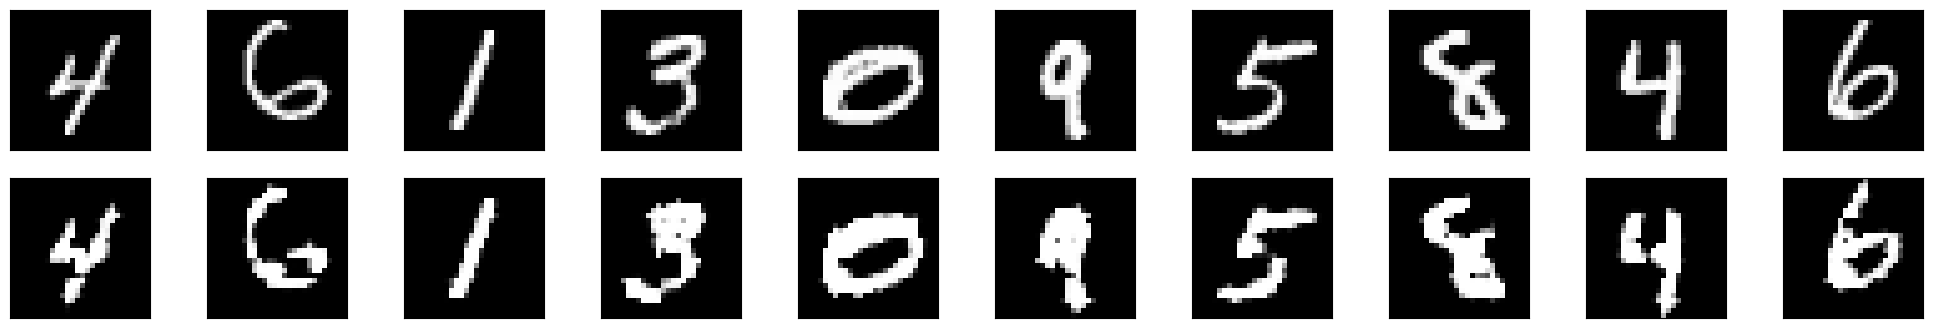

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

output = model(images)
images = images.numpy()

output = output.view(32, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

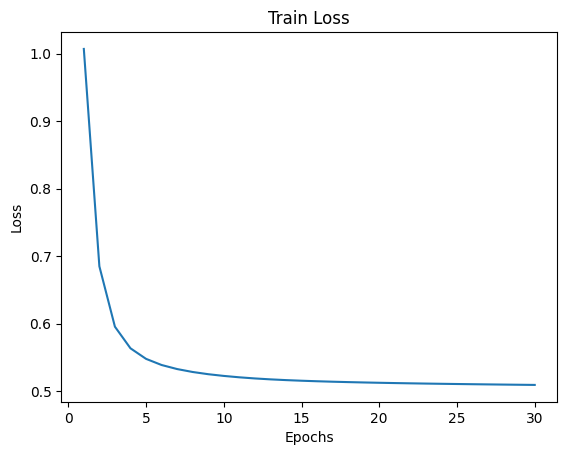

In [ ]:
plt.figure()
plt.plot(range(1, 31), losses)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
# plt.savefig('ae_loss.png')

## Gaus

In [ ]:
to_train_gc = np.zeros((1, 1, 28, 28))
ii = 0
for data in train_loader:
    images, _ = data
    to_train_gc = np.concatenate((to_train_gc, images.numpy()), axis=0)
    ii+=1
    if ii > 50:
        break
to_train_gc = np.delete(to_train_gc, (0), axis=0)

In [ ]:
to_train_gc.shape

(1632, 1, 28, 28)

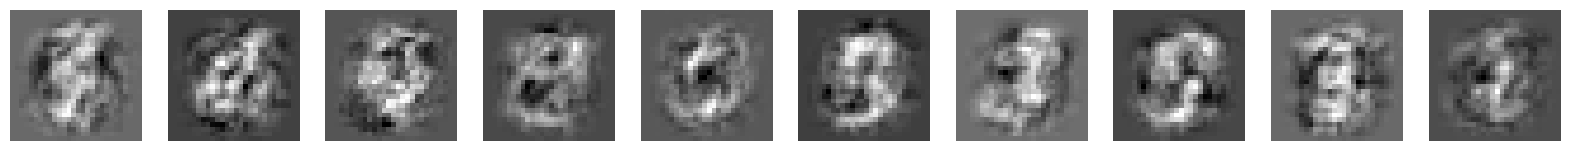

In [ ]:
X_train = to_train_gc
X_train_flat = X_train.reshape(X_train.shape[0], -1)

gauss_gen = MultivariateGaussianGenerator()
gauss_gen.fit(X_train_flat)

generated_samples = gauss_gen.generate(n_samples=10)
generated_images = generated_samples.reshape(-1, 28, 28)

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')
plt.show()

In [ ]:
encoder = model.encoder
for param in encoder.parameters():
    param.requires_grad = False

to_train_gc_latent = np.zeros((1, 16, 7, 7))
ii = 0
for data in train_loader:
    images, _ = data
    output = encoder(images)
    to_train_gc_latent = np.concatenate((to_train_gc_latent, output.numpy()), axis=0)
    ii+=1
    if ii > 50:
        break
to_train_gc_latent = np.delete(to_train_gc_latent, (0), axis=0)

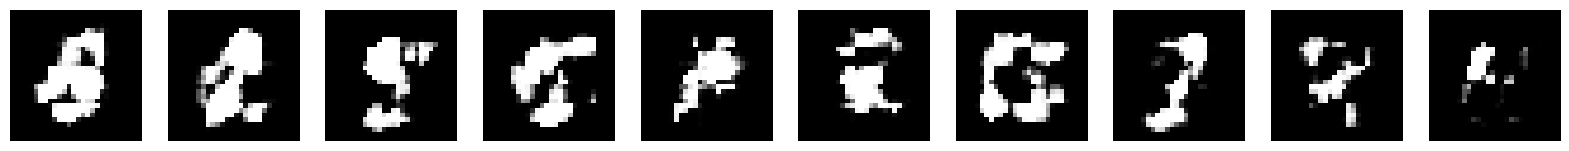

In [ ]:
X_train_flat = to_train_gc_latent.reshape(to_train_gc_latent.shape[0], -1)

gauss_gen = MultivariateGaussianGenerator()
gauss_gen.fit(X_train_flat)

generated_samples = gauss_gen.generate(n_samples=10)
generated_images = generated_samples.reshape(-1, 28, 28)
torch_tensor = torch.from_numpy(generated_images).float()
reshaped_tensor = torch_tensor.reshape(10, 16, 7, 7)

decoded_im = ae.decoder(reshaped_tensor)
decoded_im = decoded_im.view(10, 1, 28, 28)
decoded_im = decoded_im.detach().numpy()

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(decoded_im[i][0], cmap='gray')
    ax.axis('off')
plt.show()

## SMOTE

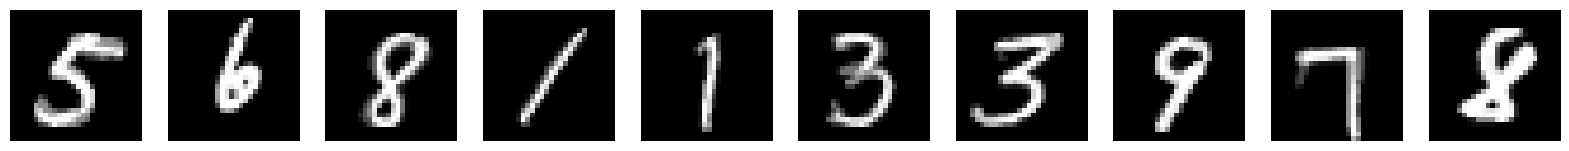

In [ ]:
X_train = to_train_gc
X_train_flat = X_train.reshape(X_train.shape[0], -1)

smote_gen = SimpleSMOTE()

generated_samples = smote_gen.generate(X_train_flat, n_samples=10)
generated_images = generated_samples.reshape(-1, 28, 28)

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')
plt.show()

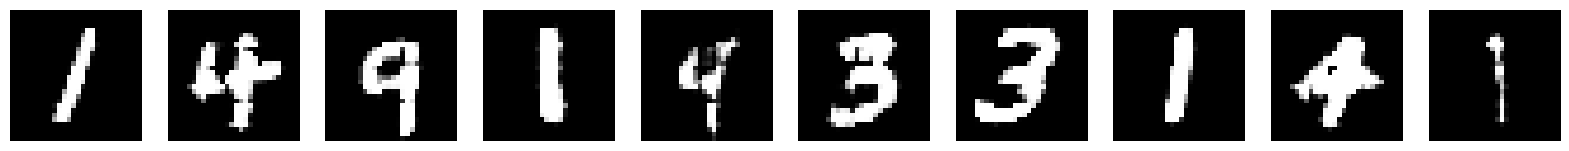

In [ ]:
X_train = to_train_gc_latent
X_train_flat = X_train.reshape(X_train.shape[0], -1)

smote_gen = SimpleSMOTE()
generated_samples = smote_gen.generate(X_train_flat, n_samples=10)
generated_images = generated_samples.reshape(-1, 28, 28)
torch_tensor = torch.from_numpy(generated_images).float()
reshaped_tensor = torch_tensor.reshape(10, 16, 7, 7)

decoded_im = ae.decoder(reshaped_tensor)
decoded_im = decoded_im.view(10, 1, 28, 28)
decoded_im = decoded_im.detach().numpy()
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(decoded_im[i][0], cmap='gray')
    ax.axis('off')
plt.show()

##Experement

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
    transforms.Lambda(lambda x: x * 2 - 1)
])

train_dataset = datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
n_class = 10
diff_steps = 1000

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
    transforms.Lambda(lambda x: x * 2 - 1)
])
class MNIST17(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None):
        self.dataset = datasets.MNIST(
            root=root,
            train=train,
            download=True,
            transform=transform
        )
        self.indices = [
            i for i, (_, label) in enumerate(self.dataset)
            if label in (1, 7)
        ]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

train_dataset = MNIST17(root='./mnist', train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [ ]:
for batch in train_loader:
    images, labels = batch
    print(labels)
    print("Уникальные метки в батче:", torch.unique(labels))
    break

tensor([7, 1, 7, 7, 1, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 7, 7, 1, 7,
        1, 7, 1, 1, 7, 7, 1, 1, 1, 7, 7, 1, 7, 7, 1, 1, 7, 7, 7, 7, 1, 1, 1, 7,
        7, 7, 1, 7, 1, 1, 1, 1, 7, 7, 1, 7, 1, 7, 1, 7, 7, 1, 1, 1, 1, 1, 7, 1,
        7, 1, 1, 7, 1, 7, 1, 1, 1, 7, 1, 1, 1, 7, 7, 1, 1, 7, 7, 7, 1, 1, 1, 7,
        7, 7, 7, 7, 1, 1, 7, 7, 7, 1, 7, 7, 7, 7, 1, 1, 1, 1, 1, 7, 1, 7, 1, 7,
        1, 1, 7, 1, 1, 7, 1, 7])
Уникальные метки в батче: tensor([1, 7])


In [ ]:
denoiser_im = ConditionalDenoiser2(n_class, 28*28, diff_steps).to(device)
denoiser_losses = train_denoiser(denoiser_im, T=diff_steps, train_loader=train_loader, n_epochs=30, save_path_model=root + "dn2_im_10_1000.pt", save_path_losses=root + "dn2_im_losses_10_1000.txt")

Epoch: 1 	Training Loss: 0.100590
Epoch: 2 	Training Loss: 0.100668
Epoch: 3 	Training Loss: 0.101139
Epoch: 4 	Training Loss: 0.100990
Epoch: 5 	Training Loss: 0.100405
Epoch: 6 	Training Loss: 0.100213
Epoch: 7 	Training Loss: 0.100637
Epoch: 8 	Training Loss: 0.100066
Epoch: 9 	Training Loss: 0.098682
Epoch: 10 	Training Loss: 0.099509
Epoch: 11 	Training Loss: 0.099406
Epoch: 12 	Training Loss: 0.098832
Epoch: 13 	Training Loss: 0.100023
Epoch: 14 	Training Loss: 0.099670
Epoch: 15 	Training Loss: 0.100644
Epoch: 16 	Training Loss: 0.099655
Epoch: 17 	Training Loss: 0.098667
Epoch: 18 	Training Loss: 0.100051
Epoch: 19 	Training Loss: 0.099229
Epoch: 20 	Training Loss: 0.098836
Epoch: 21 	Training Loss: 0.098716
Epoch: 22 	Training Loss: 0.099612
Epoch: 23 	Training Loss: 0.099375
Epoch: 24 	Training Loss: 0.099819
Epoch: 25 	Training Loss: 0.097405
Epoch: 26 	Training Loss: 0.099664
Epoch: 27 	Training Loss: 0.098638
Epoch: 28 	Training Loss: 0.098827
Epoch: 29 	Training Loss: 0.0

In [ ]:
denoiser_im = ConditionalDenoiser2(n_class, 28*28, diff_steps).to("cpu")
denoiser_im.load_state_dict(torch.load(root + "df2_10_100.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

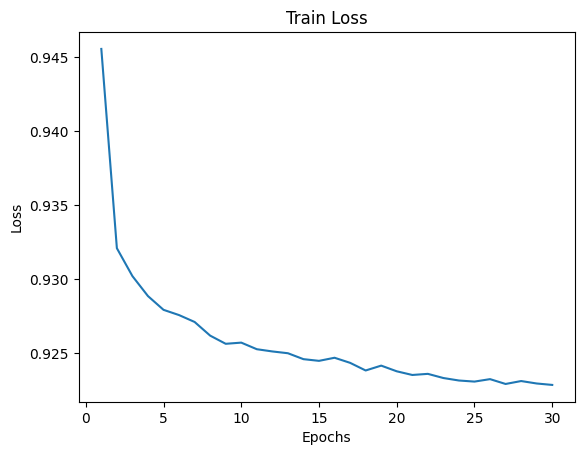

In [ ]:
denoiser_losses = load_losses(root + "df2_losses_10_100.txt")
plt.figure()
plt.plot(range(1, 31), denoiser_losses)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

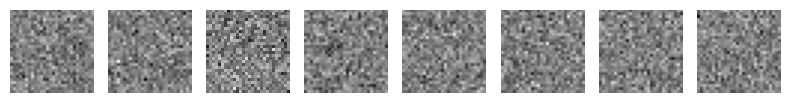

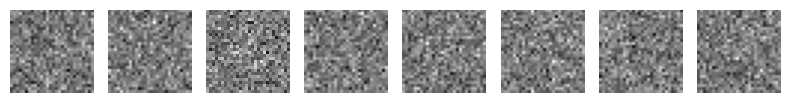

In [ ]:
generate_imgs_for_class(denoiser_im, digit=1, N=8)
generate_mixture(denoiser_im, labels=[1, 7], w1=0.5, N=8)

обученно только на лейблах 1 и 7

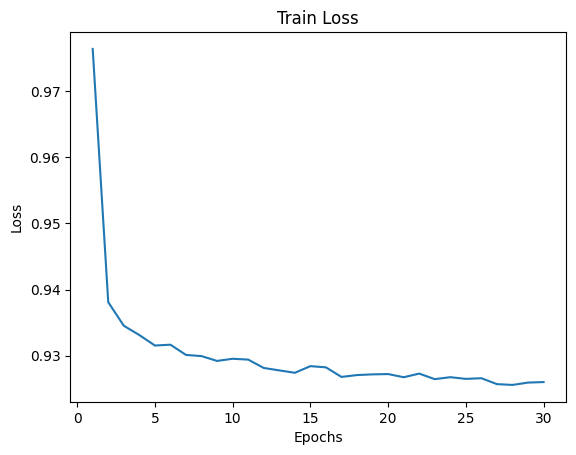

In [ ]:
denoiser_losses = load_losses(root + "df2_17_losses.txt")
plt.figure()
plt.plot(range(1, 31), denoiser_losses)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
n_class = 10
diff_steps = 1000

In [ ]:
denoiser_im = ConditionalDenoiser2(10, 28*28, 1000).to("cpu")
denoiser_im.load_state_dict(torch.load(root + "df2_17.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

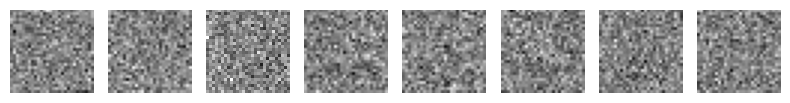

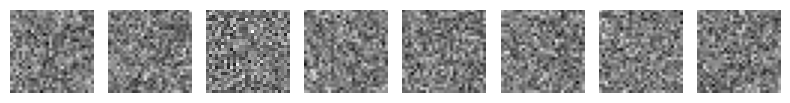

In [ ]:
generate_imgs_for_class(denoiser_im, digit=1, N=8)
generate_mixture(denoiser_im, labels=[1, 7], w1=0.5, N=8)

## DM Eb

In [ ]:
ae = Autoencoder()
ae.load_state_dict(torch.load(root + "ae_16_7_7.pt", map_location=torch.device('cpu')))
ae.eval()
for w in ae.parameters():
    w.requires_grad = False

In [ ]:
n_class = 10
diff_steps = 1000

In [ ]:
denoiser_ae = ConditionalDenoiser2(n_class, 28*28, diff_steps).to(device)
denoiser_ae_losses = train_denoiser_ae(ae, denoiser_ae, T=diff_steps, train_loader=train_loader, n_epochs=30, save_path_model=root + "df2_ae_10_100.pt", save_path_losses=root + "df2_ae_losses_10_100.txt")

Epoch: 1 	Training Loss: 0.976167
Epoch: 2 	Training Loss: 0.943650


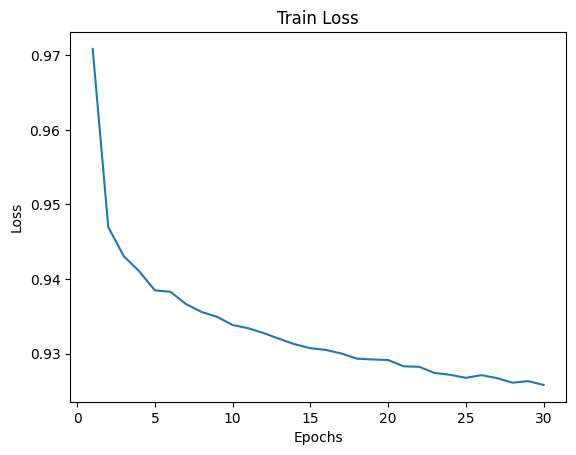

In [ ]:
denoiser_ae_losses = load_losses(root + "df2_ae_losses_10_100.txt")
plt.figure()
plt.plot(range(1, 31), denoiser_ae_losses)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
denoiser_ae = ConditionalDenoiser2(n_class, 28*28, diff_steps)
denoiser_ae.load_state_dict(torch.load(root + "df2_ae_10_100.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

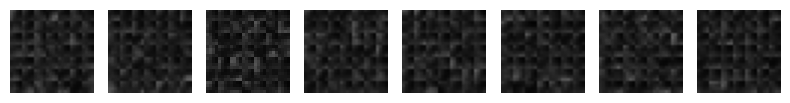

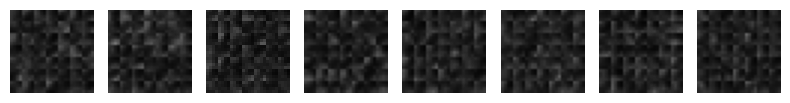

In [ ]:
generate_imgs_for_class(denoiser_ae, digit=1, N=8, T=2000, ae=ae)
generate_mixture(denoiser_ae, labels=[1, 7], w1=0.5, N=8)

обученно только на лейблах 1 и 7

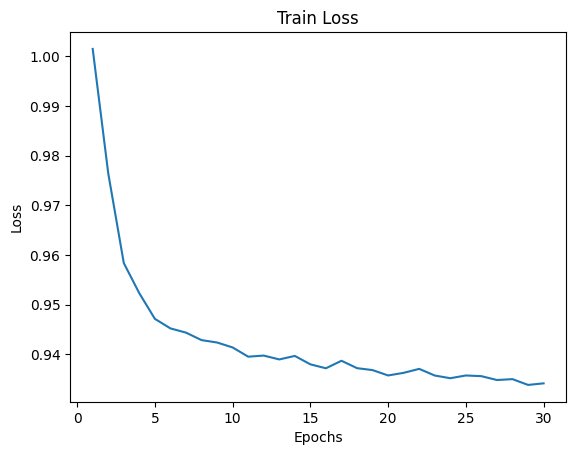

In [ ]:
denoiser_ae_losses = load_losses(root + "df2_ae_17_losses.txt")
plt.figure()
plt.plot(range(1, 31), denoiser_ae_losses)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
denoiser_ae = ConditionalDenoiser2(n_class, 28*28, diff_steps)
denoiser_ae.load_state_dict(torch.load(root + "df2_ae_17.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

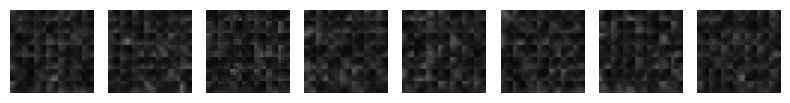

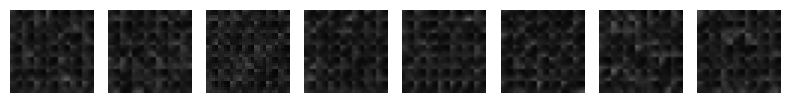

In [ ]:
generate_imgs_for_class(denoiser_ae, digit=1, N=8, T=2000, ae=ae)
generate_mixture(denoiser_ae, labels=[1, 7], w1=0.5, N=8)